In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import statsmodels.api as sm

# Load data into dataframe

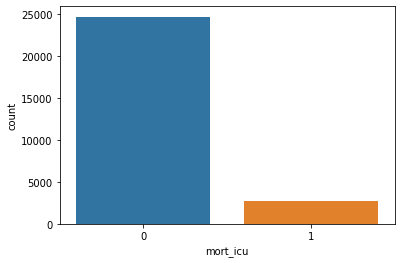

In [5]:
#load data into test and train sets
df=pd.read_csv("C:/Users/Public/Output/adult_icu/adult_icu.csv")

#Analyzing data on the basis of mortality
sns.countplot(x='mort_icu', data=df)



# Preprocessing data by standardizing (non binary columns)

In [6]:
#Center to the mean and component wise scale to unit variance
binary_cols = ['first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other', 'eth_white', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN', 'admType_URGENT']
non_binary_cols = [item for item in df.columns if item not in binary_cols]

#Scaling the data
# MimMaxScaler is used because StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_nb_scaled = scaler.fit_transform(df[non_binary_cols])
df_nb_scaled = pd.DataFrame(df_nb_scaled, columns=non_binary_cols)
df_scaled = df_nb_scaled.join(df[binary_cols])
df = df_scaled

# Seperating test and train data

In [7]:
df_test = df.loc[df['train'] == 0]
df_train = df.loc[df['train'] == 1]

# Specifying feature columns and output variable

In [8]:
#specify the feature columns and output variable
feature_cols=['age','first_hosp_stay','first_icu_stay','adult_icu','eth_asian','eth_black',
'eth_hispanic','eth_other','eth_white','admType_ELECTIVE','admType_EMERGENCY','admType_NEWBORN','admType_URGENT',
'heartrate_min','heartrate_max','heartrate_mean','sysbp_min','sysbp_max','sysbp_mean','diasbp_min','diasbp_max',
'diasbp_mean','meanbp_min','meanbp_max','meanbp_mean','resprate_min','resprate_max','resprate_mean','tempc_min',
'tempc_max','tempc_mean','spo2_min','spo2_max','spo2_mean','glucose_min','glucose_max','glucose_mean','aniongap',
'albumin','bicarbonate','bilirubin','creatinine','chloride','glucose','hematocrit','hemoglobin','lactate','magnesium',
'phosphate','platelet','potassium','ptt','inr','pt','sodium','bun','wbc']

X_train = df_train[feature_cols]
y_train = df_train.mort_icu
X_test = df_test[feature_cols]
y_test = df_test.mort_icu


# Training logistic regression model

In [10]:
logreg = LogisticRegression(solver='lbfgs',penalty='l2',max_iter=5000)
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Predicting using the trained model

In [11]:
y_pred=logreg.predict(X_test)

# Evaluating model performance: confusion matrix

In [12]:
#Confusion Matrix 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[7326,   43],
       [ 754,   59]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

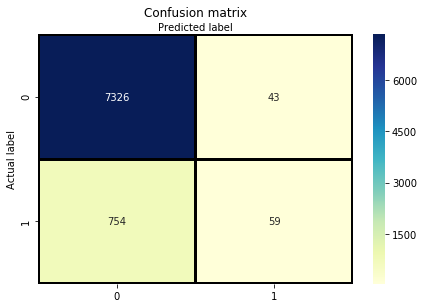

In [39]:
# Printing a heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
ax=sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',linewidths=2,linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



# Evaluating model performance: Accuracy, Precision, Recall, # of Iterations

In [29]:
#Model performance
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("No. of iterations to converge: ", logreg.n_iter_)

Accuracy: 0.9025910535321438
Precision: 0.5784313725490197
Recall: 0.07257072570725707
No. of iterations to converge:  [231]


# Evaluating model performance: ROC Curve and AUC score

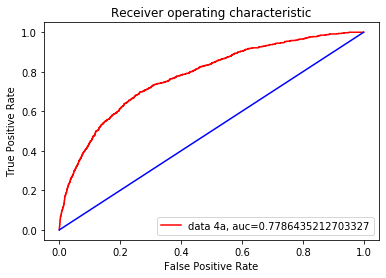

In [32]:
#ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 4a, auc="+str(auc),color='red')
plt.plot([0, 1], [0, 1], color='blue')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Evaluating top 5 risk factors of mortality and the lowest 5

In [40]:
#top five factors
print("Top 5 risk factors: ")
Coef_table=pd.DataFrame()
Coef_table['Risk factors'] = X_train.columns[:]
Coef_table['coef'] = abs(logreg.coef_[0])
Coef_table = Coef_table.sort_values('coef')
Coef_table.iloc[-5:]


Top 5 risk factors: 


,Risk factors,coef
29,tempc_max,2.315990
27,resprate_mean,2.345583
46,lactate,2.560961
28,tempc_min,3.286081
40,bilirubin,3.557763


In [41]:
print("Lowest 5 risk: ")
Coef_table.iloc[:5]

Lowest 5 risk: 


,Risk factors,coef
11,admType_NEWBORN,0.000000
8,eth_white,0.000928
36,glucose_mean,0.001172
3,adult_icu,0.006736
1,first_hosp_stay,0.006943


In [24]:
coefs=abs(logreg.coef_[0])
top_five = np.argpartition(coefs, -5)[-5:]
print("Top 5 risk factors: ")
top_three_sorted=top_five[np.argsort(coefs[top_five])]
print(np.array(feature_cols)[top_three_sorted.astype(int)])

Top 5 risk factors: 
['tempc_max' 'resprate_mean' 'lactate' 'tempc_min' 'bilirubin']


In [23]:
#lowest 5 factors
coefs=abs(logreg.coef_[0])
top_three = np.argpartition(coefs, 5)[0:5]
print("Lowest 5 risk: ")
top_three_sorted=top_three[np.argsort(coefs[top_three])]
print(np.array(feature_cols)[top_three.astype(int)])

Lowest 5 risk: 
['admType_NEWBORN' 'eth_white' 'glucose_mean' 'adult_icu'
 'first_hosp_stay']
